 ## Análise Pin People   

#### para utilizar no Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/Colab Notebooks/pin_people'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

 03092020_2kcomments.csv   03092020_2kcomments.json  'Pìn People .ipynb'


#### Bibliotecas

In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')
import os
import numpy as np
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Importando base de dados

Iniciaremos importando a base de dados (obs.: converti para .csv pela facilidade em trabalhar)

In [ ]:
df = pd.read_csv('03092020_2kcomments.csv')

In [ ]:
# visualizando a base
df.tail()

,####
1995,Seria bom aos demais que também trabalhassem c...
1996,Até aumentou.
1997,"Economia de tempo com transporte, convivio com..."
1998,"O gestor está sempre disponível, mas também nã..."
1999,"Tem sua vantagens, mas precisaria investir em ..."


In [ ]:
# alterando o nome da coluna
df.rename(columns={'####':'texto'}, inplace=True)

In [ ]:
# avaliando se há null
df.isnull().sum()

texto    2
dtype: int64

In [ ]:
# remoção dos null 
df.dropna(inplace=True)
df.isnull().sum()

texto    0
dtype: int64

#### Conhecendo um pouco da base

Inicialmente, como desconheço a base de dados, vou buscar fazer uma breve avaliação do tamanho dos frases e suas frequências.

In [ ]:
# Verificando o tamanho dos 10 "textos", por frequência
df.texto.map(len).value_counts().head(10)

78     22
3      20
106    15
45     15
54     15
117    14
89     14
81     13
93     13
101    13
Name: texto, dtype: int64

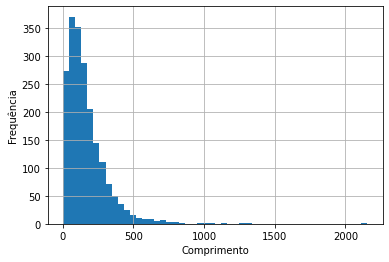

In [ ]:
# Verificando, através de um histograma,todos os comprimentos dos textos
ax = df.texto.map(len).hist(bins=50)
ax.set(xlabel='Comprimento',
       ylabel='Frequência');

Daqui podemos inferir que tmos, na grande maioria, frases com até 500 caracteres. 

### Text Minig

#### Tokenização

In [ ]:
# avaliando de um texto
df.iloc[0,0]

'Satisfação, não deixam nada a desejar...'

In [ ]:
# removendo todas as pontuações e transforma todas as palavras em minúsculas
import re

punc_re_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
df['texto_trat'] = df.texto.map(punc_re_lower)

In [ ]:
# removendo todas as palavras com números (ex: 12g)

alpha = lambda x: re.sub(r"""\w*\d\w*""", ' ',x)
df['texto_trat'] = df.texto_trat.map(alpha)


In [ ]:
df.tail

<bound method NDFrame.tail of                                                   texto                                         texto_trat
0              Satisfação, não deixam nada a desejar...           satisfação  não deixam nada a desejar   
1     Não tive dificuldade de me comunicar com outro...  não tive dificuldade de me comunicar com outro...
2     No momento, não estou trabalhando em casa, e s...  no momento  não estou trabalhando em casa  e s...
3                                       No momento não.                                    no momento não 
4           Qualidade de vinda e rendimento no trabalho        qualidade de vinda e rendimento no trabalho
...                                                 ...                                                ...
1995  Seria bom aos demais que também trabalhassem c...  seria bom aos demais que também trabalhassem c...
1996                                      Até aumentou.                                      até aumentou 
1997  E

In [ ]:
# tokenizando
from nltk.tokenize import word_tokenize

df['tokens'] = df.texto_trat.map(word_tokenize)
df.head()

,texto,texto_trat,tokens
0,"Satisfação, não deixam nada a desejar...",satisfação não deixam nada a desejar,"[satisfação, não, deixam, nada, a, desejar]"
1,Não tive dificuldade de me comunicar com outro...,não tive dificuldade de me comunicar com outro...,"[não, tive, dificuldade, de, me, comunicar, co..."
2,"No momento, não estou trabalhando em casa, e s...",no momento não estou trabalhando em casa e s...,"[no, momento, não, estou, trabalhando, em, cas..."
3,No momento não.,no momento não,"[no, momento, não]"
4,Qualidade de vinda e rendimento no trabalho,qualidade de vinda e rendimento no trabalho,"[qualidade, de, vinda, e, rendimento, no, trab..."


In [ ]:
# Criando uma lista que combina todos os valores de tokens
word_list = sum(df.tokens.tolist(), [])

In [ ]:
from collections import Counter

# Converte a lista em um dicionário com contagem de valores
word_counts = Counter(word_list)

# Inverter a chave / valores no dicionário para classificarReverter a chave / valores no dicionário para classificar
word_counts = list(zip(word_counts.values(), word_counts.keys()))

# Classifique a lista por contagem
word_counts = sorted(word_counts, reverse=True)

# Imprime as 20 palavras mais comuns
word_counts[:20]

[(2092, 'de'),
 (1806, 'e'),
 (1680, 'que'),
 (1671, 'a'),
 (1538, 'o'),
 (861, 'para'),
 (842, 'com'),
 (775, 'em'),
 (711, 'trabalho'),
 (671, 'não'),
 (667, 'é'),
 (536, 'mais'),
 (533, 'do'),
 (497, 'da'),
 (490, 'no'),
 (490, 'empresa'),
 (465, 'uma'),
 (442, 'as'),
 (424, 'os'),
 (414, 'muito')]

Aqui, já podemos verificar as palavras que mais aparecem no documento. Após um primeiro tratamento e a tokenização poderemos avançar, retirando stop words (pode-se observar uma elevada frequência delas acima).

#### Stop Words

In [ ]:
# Remova as stop words
from nltk.corpus import stopwords
nltk.download("stopwords")

# aqui utilizaremos um padrão do nltk, mas podemos criar um dicionário, caso necessário.
stop_words = stopwords.words('portuguese') 

stop_lambda = lambda x: [y for y in x if y not in stop_words]
df['tokens_stop'] = df.tokens.apply(stop_lambda)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,texto,texto_trat,tokens,tokens_stop
0,"Satisfação, não deixam nada a desejar...",satisfação não deixam nada a desejar,"[satisfação, não, deixam, nada, a, desejar]","[satisfação, deixam, nada, desejar]"
1,Não tive dificuldade de me comunicar com outro...,não tive dificuldade de me comunicar com outro...,"[não, tive, dificuldade, de, me, comunicar, co...","[dificuldade, comunicar, outros, membros, banc..."
2,"No momento, não estou trabalhando em casa, e s...",no momento não estou trabalhando em casa e s...,"[no, momento, não, estou, trabalhando, em, cas...","[momento, trabalhando, casa, sim, quarentena, ..."
3,No momento não.,no momento não,"[no, momento, não]",[momento]
4,Qualidade de vinda e rendimento no trabalho,qualidade de vinda e rendimento no trabalho,"[qualidade, de, vinda, e, rendimento, no, trab...","[qualidade, vinda, rendimento, trabalho]"


#### Stemming

In [ ]:
# Removendo as terminações de palavras alternativas sem o conhecimento do contexto. 
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('portuguese')
stem_lambda = lambda x: [stemmer.stem(y) for y in x]

df['tokens_stem'] = df.tokens_stop.apply(stem_lambda)
df.head()

# observação: tive a impressão que não funcionou muito bem para o português.

,texto,texto_trat,tokens,tokens_stop,tokens_stem
0,"Satisfação, não deixam nada a desejar...",satisfação não deixam nada a desejar,"[satisfação, não, deixam, nada, a, desejar]","[satisfação, deixam, nada, desejar]","[satisf, deix, nad, desej]"
1,Não tive dificuldade de me comunicar com outro...,não tive dificuldade de me comunicar com outro...,"[não, tive, dificuldade, de, me, comunicar, co...","[dificuldade, comunicar, outros, membros, banc...","[dificuldad, comunic, outr, membr, banc, sent,..."
2,"No momento, não estou trabalhando em casa, e s...",no momento não estou trabalhando em casa e s...,"[no, momento, não, estou, trabalhando, em, cas...","[momento, trabalhando, casa, sim, quarentena, ...","[moment, trabalh, cas, sim, quarenten, plantã,..."
3,No momento não.,no momento não,"[no, momento, não]",[momento],[moment]
4,Qualidade de vinda e rendimento no trabalho,qualidade de vinda e rendimento no trabalho,"[qualidade, de, vinda, e, rendimento, no, trab...","[qualidade, vinda, rendimento, trabalho]","[qualidad, vind, rendiment, trabalh]"


#### Alguns insigths (world clouds)

In [ ]:
# Encontrar as palavras mais comuns depois de limpar os dados

word_list_clean = sum(df.tokens_stop.tolist(), [])
word_list_clean[:10]


['satisfação',
 'deixam',
 'nada',
 'desejar',
 'dificuldade',
 'comunicar',
 'outros',
 'membros',
 'banco',
 'senti']

In [ ]:
from collections import Counter

# Converte a lista em um dicionário com contagem de valores
word_counts_clean = Counter(word_list_clean)
#a = word_counts_clean

# Inverte a chave / valores no dicionário para classificar
word_counts_clean = list(zip(word_counts_clean.values(), word_counts_clean.keys()))

# Classifica a lista por contagem
word_counts_clean = sorted(word_counts_clean, reverse=True)

# Imprime as 10 palavras mais comuns
word_counts_clean[:10]

[(711, 'trabalho'),
 (490, 'empresa'),
 (295, 'casa'),
 (283, 'remoto'),
 (238, 'tempo'),
 (231, 'bem'),
 (221, 'trabalhar'),
 (217, 'home'),
 (213, 'todos'),
 (206, 'ser')]

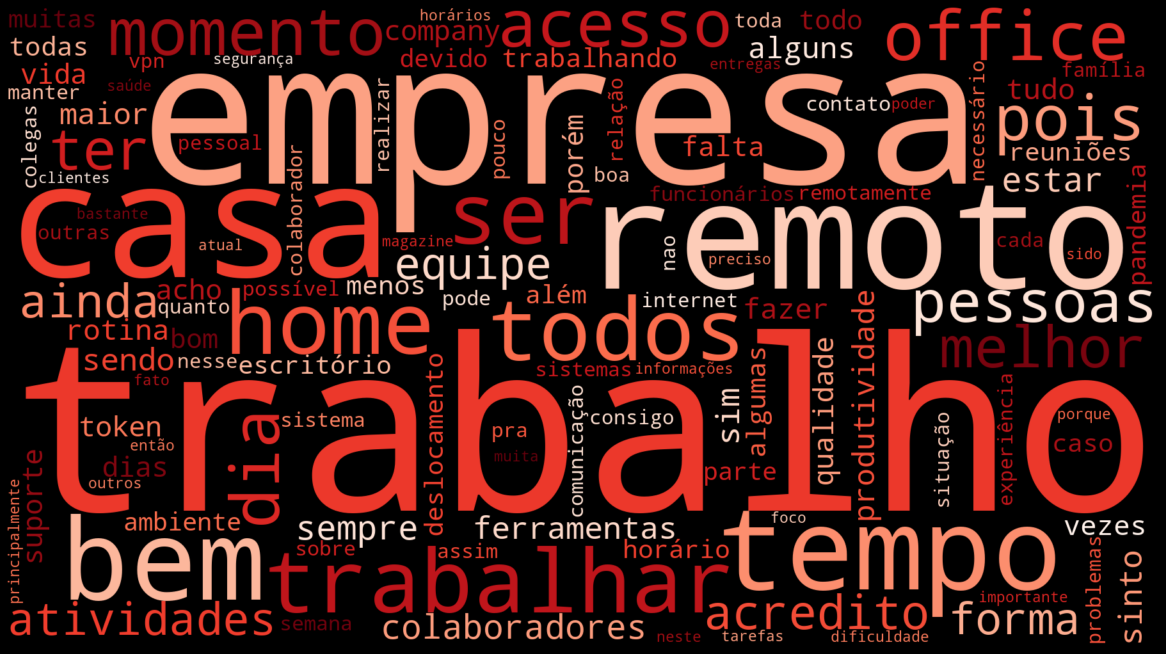

In [ ]:
word_counts_clean = Counter(word_list_clean)

# montando a word cloud
wordcloud_texto = WordCloud(background_color="black",collocations=False,
                              colormap="Reds_r",
                              width = 1800,
                              height = 1000,
                              max_font_size=600,
                              max_words=120
                             ).fit_words(word_counts_clean)
plt.figure(figsize = (16,9),
           facecolor = 'k',
           edgecolor = 'k')
plt.imshow(wordcloud_texto, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
from itertools import groupby
from gensim.similarities import WmdSimilarity
from gensim.models import Word2Vec

nltk.download('punkt') 
nltk.download('stopwords')
stop_words = stopwords.words('portuguese')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Computar bigramas e trigramas
Tópicos são muito semelhantes, o que os faria distingui-los são frases ao invés de palavras únicas / individuais.

In [ ]:
docs = word_list_clean


from gensim.models import Phrases
# add bigramas e trigramas (> 6 x).
bigram = Phrases(docs, min_count=6)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token é um bigrama, add
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token é um bigram, add
            docs[idx].append(token)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
print(bigram)

Phrases<664 vocab, min_count=6, threshold=10.0, max_vocab_size=40000000>


In [ ]:
print(trigram)

Phrases<664 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


#### Remover Tokens comuns e pouco comuns


In [ ]:
from gensim.corpora import Dictionary

# crio um dicionário representando os documentos.
dictionary = Dictionary([docs])
print('Number of unique words in initital documents:', len(dictionary))

#filtro as palavras (10 docs > palavra < 20%)  
#dictionary.filter_extremes(no_below=10, no_above=0.2)
#print('Number of unique words after removing rare and common words:', len(dictionary))


Number of unique words in initital documents: 5502


Neste exemplo, temos poucas palavras e poucos documentos, não houve necessidade de filtro (muito útil quando temos um conjunto muito grande, nos exemplos que estudei, após a filtragem ficamos com aproximadamente 4000 palavras)

#### Vetorizar dados
A primeira etapa é obter uma representação por trás das palavras de cada documento.
Passos:

1-) converter um corpus, doc2bow:converter documento (uma lista de palavras) no formato de saco de palavras = lista de (token_id, token_count)

2-) tuplas, onde cada palavra é considerada uma string tokenizada e normalizada. 


In [ ]:
corpus = [dictionary.doc2bow([doc]) for doc in docs]

In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 5502
Number of documents: 30488


### LDA
__LDA__ é uma técnica não supervisionada, o que significa que não sabemos antes de executar o modelo quantos tópicos existem em nosso corpus. A coerência do tópico é uma das principais técnicas utilizadas para desestimar o número de tópicos. 

No entanto, usei a ferramenta de visualização LDA ** pyLDAvis **.

In [ ]:
from gensim.models import LdaModel

In [ ]:
# Set training parameters.
num_topics = 3 # 4 topycs in congress
chunksize = 100 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 100
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


KeyboardInterrupt: ignored

In [ ]:
# !pip install pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
pyLDAvis.gensim.prepare(model, corpus, dictionary)

C:\Users\Daniel\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.149493 -0.109055       1        1  35.194183
0     -0.175931 -0.066314       2        1  33.791260
1      0.026438  0.175369       3        1  31.014561, topic_info=     Category        Freq           Term       Total  loglift  logprob
5133  Default  572.000000       trabalho  572.000000  30.0000  30.0000
1822  Default  348.000000        empresa  348.000000  29.0000  29.0000
5021  Default  255.000000          tempo  255.000000  28.0000  28.0000
748   Default  229.000000           casa  229.000000  27.0000  27.0000
4497  Default  224.000000         remoto  224.000000  26.0000  26.0000
53    Default  197.000000         acesso  197.000000  25.0000  25.0000
3893  Default  212.000000           pois  212.000000  24.0000  24.0000
4767  Default  196.000000            ser  196.000000  23.0000  23.0000
3538  Default  160.000000         office  160.000000  22.0000  22.0000
628   Default  175.000000            bem  175.000000  21.0000  21.0000
2630  Default  154.000000           home  154.000000  20.0000  20.0000
5123  Default  173.000000      trabalhar  173.000000  19.0000  19.0000
1559  Default  148.000000            dia  148.000000  18.0000  18.0000
5081  Default  140.000000          todos  140.000000  17.0000  17.0000
4733  Default  149.000000         sempre  149.000000  16.0000  16.0000
878   Default  135.000000  colaboradores  135.000000  15.0000  15.0000
3301  Default  133.000000        momento  133.000000  14.0000  14.0000
5040  Default  134.000000            ter  134.000000  13.0000  13.0000
227   Default  144.000000          ainda  144.000000  12.0000  12.0000
3845  Default  148.000000        pessoas  148.000000  11.0000  11.0000
1938  Default  115.000000         equipe  115.000000  10.0000  10.0000
4938  Default  118.000000        suporte  118.000000   9.0000   9.0000
2029  Default  109.000000          estar  109.000000   8.0000   8.0000
5360  Default  113.000000           vida  113.000000   7.0000   7.0000
4287  Default  100.000000      qualidade  100.000000   6.0000   6.0000
5080  Default  113.000000           todo  113.000000   5.0000   5.0000
114   Default   96.000000       acredito   96.000000   4.0000   4.0000
3219  Default  103.000000         melhor  103.000000   3.0000   3.0000
3238  Default   95.000000          menos   95.000000   2.0000   2.0000
64    Default   92.000000           acho   92.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
1559   Topic3  147.364304            dia  148.072510   1.1659  -4.1615
5081   Topic3  139.343719          todos  140.031204   1.1658  -4.2174
3301   Topic3  133.276062        momento  133.986954   1.1654  -4.2620
5040   Topic3  133.435745            ter  134.213043   1.1649  -4.2608
878    Topic3  134.612717  colaboradores  135.401108   1.1649  -4.2520
1938   Topic3  114.860954         equipe  115.585136   1.1644  -4.4107
114    Topic3   95.309608       acredito   96.026039   1.1632  -4.5973
4287   Topic3   99.614464      qualidade  100.374977   1.1631  -4.5531
2407   Topic3   83.405708          forma   84.113754   1.1623  -4.7307
3139   Topic3   81.172539          maior   81.909042   1.1617  -4.7578
4734   Topic3   73.548241          sendo   74.255936   1.1611  -4.8564
4628   Topic3   78.556717         rotina   79.333694   1.1609  -4.7906
261    Topic3   60.738873         alguns   61.426609   1.1595  -5.0478
301    Topic3   79.409821           além   80.309547   1.1594  -4.7798
1970   Topic3   63.879543     escritório   64.627083   1.1591  -4.9974
2249   Topic3   58.742157          falta   59.448635   1.1588  -5.0812
4606   Topic3   63.410233       reuniões   64.197586   1.1584  -5.0048
3842   Topic3   56.168041        pessoal   56.964241   1.1566  -5.1260
2259   Topic3   64.084465        família   65.005173   1.1564  -4.9942
3957   Topic3   56.774567       possível   57.601135   1.1563  -5.

O que vemos aqui? 

O painel esquerdo, rotulado Mapa de distância intertópica, os círculos representam diferentes tópicos e a distância entre eles. Tópicos semelhantes aparecem mais próximos e tópicos diferentes mais distantes.
O tamanho relativo do círculo de um tópico no gráfico corresponde à frequência relativa do tópico no corpus.
Um tópico individual pode ser selecionado para um exame mais detalhado clicando em seu círculo ou inserindo seu número na caixa "tópico selecionado" no canto superior esquerdo.
 
O painel direito inclui o gráfico de barras dos 30 principais termos. Quando nenhum tópico é selecionado no gráfico à esquerda, o gráfico de barras mostra os 30 termos mais "salientes" no corpus. A saliência de um termo é uma medida de quão frequente o termo é no corpus e quão "distinto" ele é na distinção entre diferentes tópicos.
Selecionar cada tópico à direita modifica o gráfico de barras para mostrar os termos "relevantes" para o tópico selecionado.
A relevância é definida como no rodapé 2 e pode ser ajustada pelo parâmetro $ \ lambda $, menor $ \ lambda $ dá maior peso à distinção do termo, enquanto $ \ lambda $ s maior corresponde à probabilidade da ocorrência do termo por tópicos.

Portanto, para ter uma noção melhor dos termos por tópico, usaremos $ \ lambda $ = 0.

In [ ]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [ ]:
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

trabalho             0.056
casa                 0.022
remoto               0.022
sempre               0.014
ainda                0.014
suporte              0.011
estar                0.011
menos                0.009
acho                 0.009
sim                  0.009
Topic 1 |---------------------

acesso               0.021
office               0.017
home                 0.016
dia                  0.016
todos                0.015
colaboradores        0.014
ter                  0.014
momento              0.014
equipe               0.012
qualidade            0.011
Topic 2 |---------------------

empresa              0.032
tempo                0.024
pois                 0.020
ser                  0.018
bem                  0.016
trabalhar            0.016
pessoas              0.014
todo                 0.011
vida                 0.011
melhor               0.010
